In [1]:
#xmlファイルを読んでピクセル座標に変換
#fitsからaperture photometryやっちゃう
import pandas as pd
import numpy as np
import matplotlib as plt
import re
import astropy.wcs
from astropy.io import fits
import astropy.io
from astropy.stats import sigma_clipped_stats
from photutils import datasets
from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from photutils import CircularAnnulus
from scipy.optimize import curve_fit
from photutils import aperture_photometry

df = pd.read_csv("simultaneous_event_candidates_table_MU+Tomo-e7.csv")
df["ID_fits"] = "d_fits/sub" + df["ID"] + ".fits"
ID_list_fits = df["ID_fits"].values
############################################ リチェックするフレーム #####
d_list = ["d_fits/sub627032_102.fits","d_fits/sub665114_014.fits"]
d_idx = np.arange(1).reshape(1) 
for i in d_list:
    for j in range(len(ID_list_fits)):
        if i == ID_list_fits[j]:
            d_idx = np.vstack((d_idx, j))
d_idx = np.delete(d_idx,0)
print ID_list_fits[d_idx]
df = df.drop(d_idx)
###############################################################
df["ID_xml"] = "sub" + df["ID"] + ".xml"
df["ID_fits"] = "d_fits/sub" + df["ID"] + ".fits"
ID_list_xml = df["ID_xml"].values
ID_list_fits = df["ID_fits"].values
meteor_flux_list = df["flux_meteor"].values

def gauss(x, A, mu, sigma):
    return A / np.sqrt(2.0*np.pi) / sigma * np.exp(-((x-mu)/sigma)**2/2)

with open("d_xml/sub571226_095.xml") as f:
    a = f.readlines()
    b = a[50]#<TABLEDATA>
    c = a[77] #</TABLEDATA>

mag_vr = np.arange(1).reshape(1)#starと比較して最終的に流星のmag_videorateが欲しい
star_num = np.arange(1).reshape(1)
dispersion = np.arange(1).reshape(1)
for (filename_fits, filename_xml,idx) in zip(ID_list_fits, ID_list_xml,range(len(ID_list_fits))):
    filename_xml = "d_xml/" + filename_xml
    meteor_flux = meteor_flux_list[idx]
    print filename_fits,meteor_flux
###################################### xml ファイルの読み込み #######
#################################恒星の(ra, dec, Vmag)のリストにする###
    with open(filename_xml) as f:
        l = f.readlines()
        for i in range(len(l)):
            m = l[i]
            if m == b:
                del_start = i + 1
            elif m == c:
                del_end = i
    l = l[del_start:del_end]
    xml = l[0]
    xml = re.split('<TR><TD>|</TD><TD>|</TD></TR>', xml)
    del xml[0],xml[2:8],xml[3:]
    for i in l:
        s = re.split('<TR><TD>|</TD><TD>|</TD></TR>', i)
        del s[0],s[2:8],s[3:]
        xml = np.vstack((xml, s))
    xml = np.delete(xml,0, 0)
    xml = xml.astype(np.float64)
##############################################################
######################## World Coordinates System to Pixel Coordinates ###
    pixel_coordinates = np.arange(2).reshape(1,2)
    fits = astropy.io.fits.open(filename_fits)
    hdul = fits
    data = hdul[0].data
    data2 = data[1,:,:]#差分前のフレームだけにする
    data2 = np.reshape(data2, (282, 500))#2次元化
    wcs = astropy.wcs.WCS(fits[0].header, naxis = 2)
    for j in range(len(xml)):
            pixel_coord = wcs.all_world2pix(xml[j,0], xml[j,1], 1)
            pixel_coordinates = np.vstack((pixel_coordinates, pixel_coord))
    pixel_coordinates = np.delete(pixel_coordinates,0, 0)
###############################################################
################################# Remove the stars outside the frame ###
    index = np.arange(1).reshape(1)
    for i in range(len(pixel_coordinates)):
        x = pixel_coordinates[i,0]
        y = pixel_coordinates[i,1]
        if (x < 0) or (x > 490) or (y < 0) or (y > 282):
#x座標が490なのはガウスフィットするときに±10pix抜き出すからはみ出ないように490に設定
            index = np.vstack((index, i))
    index = np.delete(index,0, 0)
    pixel_coordinates = np.delete(pixel_coordinates,index, 0)
    xml = np.delete(xml,index, 0)
    vmag = xml[:,2]
###############################################################
############ Gaussian profile of catalog stars to estimate aperture's parameters ###
    star_flux = np.arange(1).reshape(1)
    for i in range(len(pixel_coordinates)):
        xr1 = pixel_coordinates[i,0] - 10
        xr2 = pixel_coordinates[i,0] + 10
        xr1 = xr1.astype(int)
        xr2 = xr2.astype(int)
        xr = range(xr1, xr2, 1)
        yr = pixel_coordinates[i,1]
        yr = yr.astype(int)
        y =  data2[yr,xr]
        A_para = y.max()
        mu_para = pixel_coordinates[i,0]
        p0 = [A_para, mu_para, 1.] # パラメータの初期値(A, mu, sigma)
        parameter,_ = curve_fit(gauss, xr, y, p0=p0)
        sigma = parameter[2]
        fwhm = 2*parameter[2]*(np.sqrt(2*np.log(2)))
        xx = np.linspace(xr1, xr2, 100)
        yy = gauss(xx, *parameter)
        #ax = plt.subplot()
        #ax.plot(xr, y, 'c.')
        #ax.plot(xx, yy, 'r-')
        #plt.show()
        #file_name = star_photometry_filename[i]
        #plt.savefig(file_name)
        
##################################################################
####################################### Conducting aperture photometry ###
        positions = pixel_coordinates[i,:]
        aperture_radius = 1.5*fwhm
        inner_radius = aperture_radius + fwhm
        outer_radius = 5*fwhm
        apertures = CircularAperture(positions, r=aperture_radius)
        annulus_apertures = CircularAnnulus(positions, r_in=inner_radius, r_out=outer_radius)
        apers = [apertures, annulus_apertures]
        phot_table = aperture_photometry(data2, apers)
        for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'
        bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
        bkg_sum = bkg_mean * apertures.area()
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['residual_aperture_sum'] = final_sum
        phot_table['residual_aperture_sum'].info.format = '%.8g'
        aperture_sum = np.array(phot_table["residual_aperture_sum"][:])
        star_flux = np.vstack((star_flux, aperture_sum))
        #print (phot_table)
        #print aperture_sum
    star_flux = np.delete(star_flux,0, 0)
    if len(xml)==0: #カタログ恒星がすべてフレーム外だった場合
            xml = np.zeros((1,3))
            star_flux = np.zeros((1,1))
    xml = np.hstack((xml,star_flux))
###################################################################
####################################  Comparison star flux and meteor flux ###
    m_vr = np.arange(1).reshape(1)
    for i in range(len(xml)):
        video_rate_magnitude = xml[i,2] - 2.5*np.log10(meteor_flux/xml[i,3]) 
        m_vr = np.vstack((m_vr, video_rate_magnitude))
    m_vr = np.delete(m_vr,0, 0)
    star_number = len(m_vr)
    m_average = np.average(m_vr)
    deviation = m_vr - m_average
    deviation = np.power(deviation,2)
    disp = np.sqrt(np.sum(deviation)/len(m_vr))
    #xml = np.hstack((xml,m_vr))
    m_vr = np.average(m_vr)
    mag_vr = np.hstack((mag_vr,m_vr))
    star_num = np.hstack((star_num,star_number))
    dispersion = np.hstack((dispersion,disp))

mag_vr = np.delete(mag_vr,0, 0)
star_num = np.delete(star_num,0, 0)
dispersion = np.delete(dispersion,0, 0)
###############################################################絶対等級
alt = df["Beginning_height_km_"].values #[km]
#alt = alt*10**3 #[m]
distance = 170 #[km]
#distance = 170*10**3 #[m]
alt = np.power(alt, 2)
distance = np.power(distance, 2)
l = alt + distance
l = l.astype(np.float64)
l = np.sqrt(l)
#pc = l/(3.085677581*10**6)
#abs_mag = mag_vr + 5 - 5*np.log10(pc)
abs_mag = mag_vr + 10 - 5*np.log10(l) #100km換算の絶対等級
###################################################################
for i in range(len(meteor_flux_list)): ## 流星のフラックスが測れてない場合等級もゼロにする
    if meteor_flux_list[i] == 0:
        mag_vr[i] = 0
        abs_mag[i] = 0

df["mag_vr"] = mag_vr
df["mag_err"] = dispersion
df["star_num"] = star_num
df["abs_mag"] = abs_mag
###################################################################
####################################  Create new .csv file ###
#df = pd.concat([df, df_mag_vr], axis=1)
Columns = df.columns
for i in range(len(Columns)):
    if Columns[i] == "ID":
        index = i
Columns = Columns[0:index]
df = df.drop(columns=Columns)
df = df.drop(columns="ID_xml")
df = df.drop(columns="ID_fits")
#df.to_csv("aaaaa.csv")
df.to_csv("simultaneous_event_candidates_table_MU+Tomo-e8.csv")
print "Complete!"
####################################################################


### aperture内に他のsourceがある場合、除く
### 流星の飛跡付近のマスキング
### 

['d_fits/sub627032_102.fits' 'd_fits/sub665114_014.fits']
d_fits/sub571226_095.fits 5497577.35724652
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the

/Users/akira/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:159: RuntimeWarning: divide by zero encountered in log10
/Users/akira/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in subtract


d_fits/sub572125_014.fits 2754443.79451474
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub572534_007.fits 0.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy

/Users/akira/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in log10


d_fits/sub573712_037.fits 3353643.16007427
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub574521_070.fits 240306186.768726
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub576013_041.fits 7988714.02001041
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub577523_013

d_fits/sub578823_051.fits 3291476.79006678
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub581511_005.fits 7861693.33509823
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub582332_030

d_fits/sub582715_091.fits 252954091.32736698
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

          

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub584324_067

d_fits/sub585822_113.fits 25172258.216675602
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

          

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub586013_041

d_fits/sub586316_110.fits 0.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub586414_116

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub586612_016

d_fits/sub586715_074.fits 2947623.03513026
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub586813_057.fits 1335166.51062022
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub586911_016.fits 946982.499183462
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub587026_111.fits 2729706.05952271
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub587223_107.fits 4834204.00919614
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub587432_100

d_fits/sub587721_047.fits 4424681.73401767
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub588113_020.fits 8405992.96541019
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub588144_046

d_fits/sub588515_007.fits 22856848.114322
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

             

d_fits/sub588732_052.fits 44617413.4162193
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub588934_011

d_fits/sub589134_108.fits 2334146.55438644
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub589331_053.fits 2788402.90903555
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub589625_016

d_fits/sub589822_043.fits 1908354.91338573
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub590112_028

d_fits/sub590613_098.fits 1279727.90432761
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub591023_034

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub591614_065

d_fits/sub600623_111.fits 1786876.60603523
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub604512_062.fits 226842.0956943
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

              

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub606914_053

d_fits/sub607713_045.fits 3328759.73689428
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub608412_117

d_fits/sub610023_093.fits 1766902.37008034
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub611031_093

d_fits/sub611921_091.fits 281081.02983911603
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

          

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub613033_007

d_fits/sub614031_048.fits 625595.469256678
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub614113_116

d_fits/sub614722_075.fits 6845624.65999458
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub616032_114.fits 557380.956410656
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub617112_118.fits 3190461.62842553
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub618312_007

d_fits/sub618622_062.fits 1944486.00967449
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub619514_094

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub619731_107

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub619841_072

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub620214_100

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub620433_073

d_fits/sub621426_003.fits 12380604.455715302
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

          

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub622314_002

d_fits/sub622713_019.fits 1215066.70424556
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub622743_091

d_fits/sub622841_095.fits 0.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub623222_097

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub623423_081

/Users/akira/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:159: RuntimeWarning: divide by zero encountered in double_scalars


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub623541_033

d_fits/sub624223_012.fits 2007505.89210131
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub624622_075.fits 785107.752495911
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub625422_110

d_fits/sub625542_019.fits 54969573.0805435
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub625812_034.fits 366018163.912173
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub625911_107

d_fits/sub626142_088.fits 0.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy

d_fits/sub626641_099.fits 1299610.10397999
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub627623_031.fits 1652752.49623518
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub627844_025

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub628225_084

d_fits/sub628522_018.fits 3843733.21399947
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub628821_111.fits 2774220.52079285
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub628943_015

d_fits/sub629316_065.fits 3160256.33406033
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub629514_036

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub629623_013

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub629811_096

/Users/akira/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in double_scalars


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub630132_066

d_fits/sub630434_043.fits 47531.246250815995
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

          

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub630831_099

d_fits/sub640822_080.fits 99030619.3001842
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub643521_029.fits 3381466.14363426
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub646515_039.fits 593864.603974434
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub648023_061.fits 1726975.31006768
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub649544_005.fits 15361884.2081714
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub650212_045

d_fits/sub650324_010.fits 386607.822621018
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub650813_016.fits 5795268.035486099
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

           

d_fits/sub651344_043.fits 973616.239097945
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub652311_070.fits 0.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub652721_054

d_fits/sub653643_005.fits 4059369.34425457
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub654412_064

d_fits/sub654616_112.fits 1904809.54657934
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub654913_084.fits 853270.701896678
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub655512_102.fits 0.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub656811_092

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub657112_030

d_fits/sub657414_004.fits 12863412.836014
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub658513_118

d_fits/sub658915_074.fits 4814492.47955197
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub660011_062

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub660515_012

d_fits/sub661214_005.fits 7966929.12031518
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub661514_085

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub662315_014

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub662615_074

d_fits/sub663434_069.fits 1276352.08037789
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub663842_076.fits 747198.665881642
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub664421_013.fits 4345613.22588268
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub664732_047

d_fits/sub664812_042.fits 3199929.61643956
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub665122_084

d_fits/sub665611_082.fits 7444204.06893804
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub665631_066.fits 12351472.7608159
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub665924_018.fits 102668380.478151
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub666044_095.fits 1208698.35009608
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub666623_108.fits 532638.485861484
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub666912_019

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub669013_117

d_fits/sub669032_056.fits 8558893.68903227
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub670133_115.fits 3131627.34873357
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub670233_041.fits 736109.457690347
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub670423_006.fits 2791702.5347166
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

             

d_fits/sub670524_101.fits 8900726.06562547
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub670812_093.fits 6542418.03147234
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub671044_051

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub671521_067

d_fits/sub671625_114.fits 1772668.81539256
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub671932_066.fits 822383.159200831
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub672221_094

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub673531_094

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub673933_048

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub681214_095

d_fits/sub681723_107.fits 2045082.13040687
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub683134_055

d_fits/sub684322_022.fits 1606729.8169068
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub686214_089

d_fits/sub686921_099.fits 2253175.23599783
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub687924_033.fits 3706593.04111762
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub689512_054.fits 5806893.31191464
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub690012_102.fits 384618.85277722
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub690212_116

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub690721_033

d_fits/sub691434_107.fits 3151701.43760233
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub692332_076.fits 4672.50191516999
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub692926_057.fits 113541.806686878
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub693332_057.fits 58212243.428757
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub693613_097

d_fits/sub693821_040.fits 1027357.23888219
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub694131_009.fits 1737750.98427651
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub694344_015

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub694514_038

d_fits/sub695413_045.fits 0.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub696513_090

d_fits/sub696725_066.fits 3902753.83613591
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub696914_039

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub697132_038

d_fits/sub697714_016.fits 0.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy

d_fits/sub698214_071.fits 582140.98096265
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

             

d_fits/sub698642_096.fits 0.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy

d_fits/sub699022_047.fits 0.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub699332_085

d_fits/sub699621_039.fits 2585281.401805
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

              

d_fits/sub699821_031.fits 5841365.14475277
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub700421_050.fits 37594892.9423506
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub700744_067.fits 3568914.53791199
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub700842_046.fits 1407606.2185674
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

             

d_fits/sub701514_110.fits 1210425.51500681
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub702114_030

d_fits/sub702526_060.fits 1613020.03881063
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub702823_111

d_fits/sub702931_049.fits 23196560.3839631
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub703325_030.fits 1944660.61618625
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub703526_047.fits 663373.19870171
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

             

d_fits/sub703842_108.fits 6095892.91212318
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub703944_092

d_fits/sub704224_047.fits 1190046.45837908
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub704316_034.fits 348668.580175507
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub704714_042.fits 4386665.97703614
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub704821_003

d_fits/sub705124_087.fits 4833360.26143161
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub705222_077.fits 53764821.7456764
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

d_fits/sub705426_081.fits 1818964.52587535
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub705532_023

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub705716_060

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub706115_046

d_fits/sub706534_072.fits 584842.583148245
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

            

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub707034_071

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
d_fits/sub707311_055

In [52]:
#xmlファイルを読んでピクセル座標に変換
#fitsからaperture photometryやっちゃう
### 単体のファイルだけ、テストver.
import pandas as pd
import numpy as np
import re
import astropy.wcs
from astropy.io import fits
import astropy.io
from astropy.stats import sigma_clipped_stats
from photutils import datasets
from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from photutils import CircularAnnulus
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

df = pd.read_csv("aaaa.csv")
#df = pd.read_csv("simultaneous_event_candidates_table_MU+Tomo-e7.csv")
df["ID_xml"] = "sub" + df["ID"] + ".xml"
df["ID_fits"] = "sub" + df["ID"] + ".fits"
ID_list_xml = df["ID_xml"].values
ID_list_fits = df["ID_fits"].values
meteor_flux = df["flux_meteor"].values
with open("d_xml/sub571226_095.xml") as f:
    a = f.readlines()
    b = a[50]#<TABLEDATA>
    c = a[77] #</TABLEDATA>

def gauss(x, A, mu, sigma):
    return A / np.sqrt(2.0*np.pi) / sigma * np.exp(-((x-mu)/sigma)**2/2)
#################################################################
###################################### xml ファイルの読み込み #######
with open("d_xml/sub627032_102.xml") as f:
    l = f.readlines()
    for i in range(len(l)):
        m = l[i]
        if m == b:
            del_start = i + 1
        elif m == c:
            del_end = i
l = l[del_start:del_end]
xml = l[0]
xml = re.split('<TR><TD>|</TD><TD>|</TD></TR>', xml)
del xml[0],xml[2:8],xml[3:]
for i in l:
    s = re.split('<TR><TD>|</TD><TD>|</TD></TR>', i)
    del s[0],s[2:8],s[3:]
    xml = np.vstack((xml, s))
xml = np.delete(xml,0, 0)
xml = xml.astype(np.float64)
#################################################################
############################ World Coordinates System to Pixel Coordinates ###
pixel_coordinates = np.arange(2).reshape(1,2)
fits = astropy.io.fits.open("sub627032_102.fits")
hdul = fits
data = hdul[0].data
data2 = data[1,:,:]#差分前のフレームだけにする
data2 = np.reshape(data2, (282, 500))#2次元化
wcs = astropy.wcs.WCS(fits[0].header, naxis = 2)
for j in range(len(xml)):
        pixel_coord = wcs.all_world2pix(xml[j,0], xml[j,1], 1)
        pixel_coordinates = np.vstack((pixel_coordinates, pixel_coord))
pixel_coordinates = np.delete(pixel_coordinates,0, 0)

##################################### Remove the stars outside the frame ###
index = np.arange(1).reshape(1)
for i in range(len(pixel_coordinates)):
    x = pixel_coordinates[i,0]
    y = pixel_coordinates[i,1]
    if (x < 0) or (x > 500) or (y < 0) or (y > 282):
        index = np.vstack((index, i))
index = np.delete(index,0, 0)
pixel_coordinates = np.delete(pixel_coordinates,index, 0)
xml = np.delete(xml,index, 0)
vmag = xml[:,2]
###############################################################
############ Gaussian profile of catalog stars to estimate aperture's parameters ###
star_flux = np.arange(1).reshape(1)
for i in range(len(pixel_coordinates)):
    xr1 = pixel_coordinates[i,0] - 10
    xr2 = pixel_coordinates[i,0] + 10
    xr1 = xr1.astype(int)
    xr2 = xr2.astype(int)
    xr = range(xr1, xr2, 1)
    yr = pixel_coordinates[i,1]
    yr = yr.astype(int)
    y =  data2[yr,xr]
    A_para = y.max()
    mu_para = pixel_coordinates[i,0]
    p0 = [A_para, mu_para, 1.] # パラメータの初期値(A, mu, sigma)
    parameter,_ = curve_fit(gauss, xr, y, p0=p0)
    sigma = parameter[2]
    fwhm = 2*parameter[2]*(np.sqrt(2*np.log(2)))
    xx = np.linspace(xr1, xr2, 100)
    yy = gauss(xx, *parameter)
    #ax = plt.subplot()
    #ax.plot(xr, y, 'c.')
    #ax.plot(xx, yy, 'r-')
    #plt.show()
    #file_name = star_photometry_filename[i]
    #plt.savefig(file_name)
##################################################################
####################################### Conducting aperture photometry ###
    positions = pixel_coordinates[i,:]
    if fwhm < 0: #ガウシアンフィットガ上手くいってない,l125でstar_fluxをゼロにする
        fwhm = 0.001
    print fwhm
    aperture_radius = 1.5*fwhm
    inner_radius = aperture_radius + fwhm
    outer_radius = 5*fwhm
    apertures = CircularAperture(positions, r=aperture_radius)
    annulus_apertures = CircularAnnulus(positions, r_in=inner_radius, r_out=outer_radius)
    apers = [apertures, annulus_apertures]
    phot_table = aperture_photometry(data2, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
    bkg_sum = bkg_mean * apertures.area()
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    phot_table['residual_aperture_sum'].info.format = '%.8g'
    aperture_sum = np.array(phot_table["residual_aperture_sum"][:])
    #if fwhm < 0:
        #aperture_sum = 0.0
    star_flux = np.vstack((star_flux, aperture_sum))
    #print (phot_table)
    #print aperture_sum
star_flux = np.delete(star_flux,0, 0)
if len(xml)==0: #カタログ恒星がすべてフレーム外だった場合
    xml = np.zeros((1,3))
    star_flux = np.zeros((1,1))
xml = np.hstack((xml,star_flux))
print xml, xml.shape
###############################################################
################################  Conparetion star flux and meteor flux ###
m_vr = np.arange(1).reshape(1)
for i in range(len(xml)):
    video_rate_magnitude = xml[i,2] - 2.5*np.log10(meteor_flux[0]/xml[i,3]) 
    m_vr = np.vstack((m_vr, video_rate_magnitude))
m_vr = np.delete(m_vr,0, 0)
xml = np.hstack((xml,m_vr))
mag_vr = np.average(m_vr)
#columns = ["mag_vr"]
#df_exposure_starting_time = pd.DataFrame(data = mag_vr, columns = columns)
print "Complete!"
###############################################################

################################# aperture内に他のsourceがある場合、除く####
################################# 流星の飛跡付近のマスキング###
##################################################################
################################ Source Extractor #### 現時点でいらないかも
"""
mean, median, std = sigma_clipped_stats(data2, sigma=3.0)    
daofind = DAOStarFinder(fwhm=3.0, threshold=20.*std)    
sources = daofind(data2 - median)    
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output

xcentroids = np.array(sources["xcentroid"][:])
ycentroids = np.array(sources["ycentroid"][:])
centroids = np.vstack((xcentroids, ycentroids))
centroids = centroids.transpose()

######################################## Math Catalog stars and Source Extractor ###
##### Catalogのリストと Source Extractorのリストを比較,距離が最も近いものを同じとみなす###
idx = np.arange(1).reshape(1)
x = pixel_coordinates[:,0]
y = pixel_coordinates[:,1]
xcentroids = centroids[:,0]
ycentroids = centroids[:,1]
for i in range(len(x)):
    a = np.abs(xcentroids - x[i])
    b = np.abs(ycentroids - y[i])
    c = a + b
    idx1 = c.argmin()
    idx = np.vstack((idx, idx1))
idx = np.delete(idx,0, 0) # centroids[idx] is modified centroids of catalg stars
centroids_star = np.arange(2).reshape(1,2)
for i in idx:
    center = centroids[i,:]
    centroids_star = np.vstack((centroids_star, center))
centroids_star = np.delete(centroids_star,0, 0) 
print centroids_star
"""

3.04751307662247
0.23244646140494013
0.001
9.71923756503931
0.33214597995350625
2990.4368735323796


KeyboardInterrupt: 

Complete!


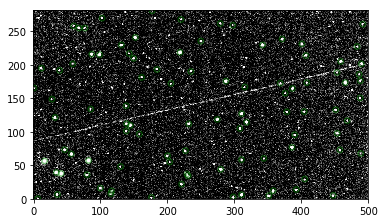

In [2]:
from astropy.stats import sigma_clipped_stats
from photutils import datasets
import pandas as pd
import numpy as np
import astropy.io
import matplotlib.pyplot as plt
from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

hdul = astropy.io.fits.open("d_fits/sub571226_095.fits")
data = hdul[0].data
data2 = data[1,:,:]#差分前のフレームだけにする
data2 = np.reshape(data2, (282, 500))#2次元化
mean, median, std = sigma_clipped_stats(data2, sigma=3.0)    
#print((mean, median, std))  
daofind = DAOStarFinder(fwhm=3.0, threshold=20.*std)    
sources = daofind(data2 - median)    
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output
#print sources
#print sources["xcentroid"][:]
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)
plt.imshow(data2, cmap = 'gray', vmin = 0, vmax = 400, interpolation = 'none')
apertures.plot(color='green', lw=1.5, alpha=0.5)
plt.ylim(0, 282)
print "Complete!"